# 📚 Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img

# Define Constants

In [2]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

# Set directories dynamically
train_dir = os.path.join(path, "Training")
test_dir  = os.path.join(path, "Testing")

img_size = (224, 224)
batch_size = 32

print("Train directory:", train_dir)
print("Test directory:", test_dir)


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Train directory: /kaggle/input/brain-tumor-mri-dataset/Training
Test directory: /kaggle/input/brain-tumor-mri-dataset/Testing


In [3]:
print(os.listdir(path))
print(os.listdir(train_dir))
print(os.listdir(test_dir))


['Training', 'Testing']
['pituitary', 'notumor', 'meningioma', 'glioma']
['pituitary', 'notumor', 'meningioma', 'glioma']


# Getting the data 🔽

In [4]:
#Define train_data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "int" ,
    batch_size = batch_size ,
    )

#Define Classes Names
class_names= train_data.class_names
class_names


Found 5712 files belonging to 4 classes.


['glioma', 'meningioma', 'notumor', 'pituitary']

## Explore the data 🔎


##  visualizing some Random Samples

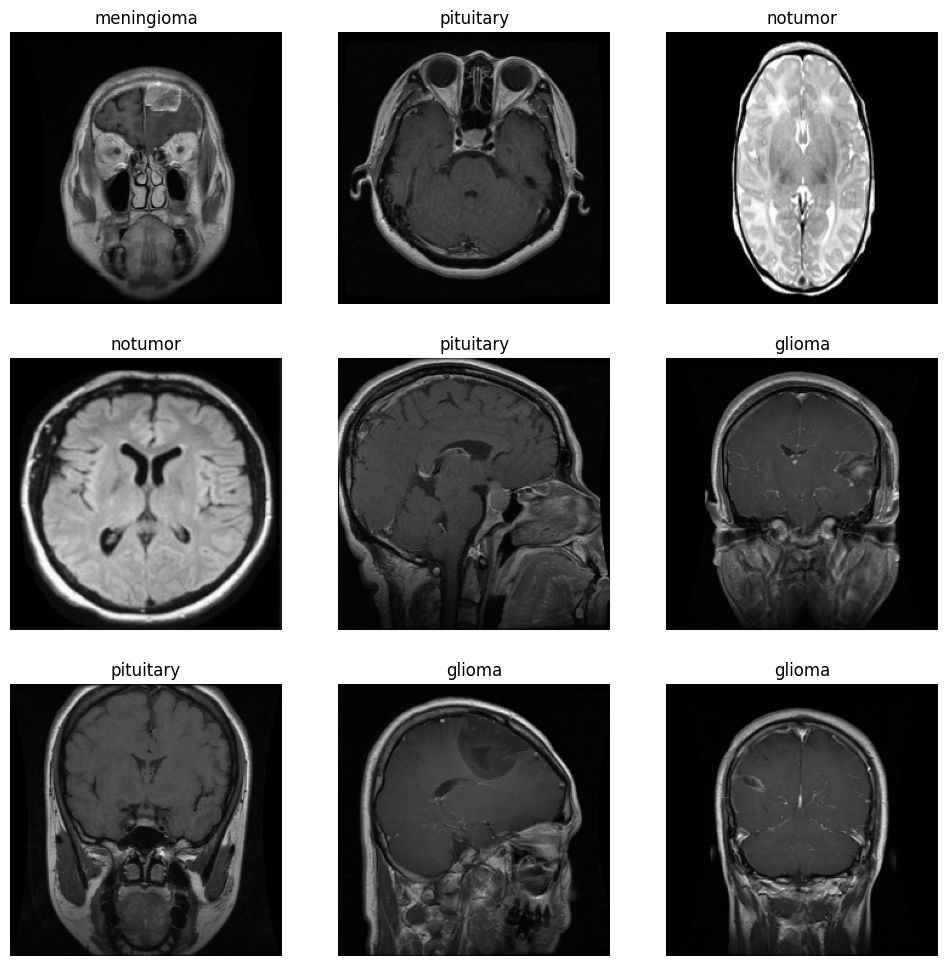

In [6]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Imbalanced data Check


In [7]:
#Deifne a Function to get number of each class samples
def each_class_samples(train_data):
    """
    taking the train data and returns the number of each class samples

    """
    #Set up counters
    meningioma = 0
    notumor = 0
    glioma = 0
    pituitary = 0

    #Looping over the train_data
    for images, labels in train_data:
        for i in range(len(images)):
            if class_names[labels[i]] == 'meningioma':
                meningioma +=1
            elif class_names[labels[i]] == 'notumor':
                notumor +=1
            elif class_names[labels[i]] == 'glioma':
                glioma +=1
            elif class_names[labels[i]] == 'pituitary':
                pituitary +=1
    print("meningioma : " + str(meningioma))
    print("glioma : " + str(glioma))
    print("notumor : " + str(notumor))
    print("pituitary : " + str(pituitary))
    return [meningioma , glioma , notumor , pituitary]




#Trying our function
meningioma  , glioma , notumor , pituitary = each_class_samples(train_data)

meningioma : 1339
glioma : 1321
notumor : 1595
pituitary : 1457


In [8]:
# Plotting numbers of each class
fig = go.Figure(go.Bar(
            x= [meningioma,glioma,pituitary,notumor],
            y= ['meningioma','glioma','pituitary','notumor'],
            orientation='h' ,) )

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)


fig.show()

#  Modelling_1 (Using EfficientNetB0)

## Defining Data and callBack_List


In [9]:
#Defining some constants
img_size = (224 , 224)
batch_size = 32


#Defining train_data again
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining Test_data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining CallBack list

callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


## Modelling
* First Stage : BaseModel(Freezed) . add[Conv2D layer(`will help us in the segmentation part`)] . add[Global avg pooling layer] . add[Dense Layer] and train for 5 epochs
* Second Stage: BaseModel(un freeze last 10 layers) . ReCompile[and reduce learning rate by 10x]
* Last : [Apply Grad Cam Segmentation]

### 1.First Stage - Building the model



In [10]:

#--Define Base_Model (EfficientNetB0)

base_model = tf.keras.applications.EfficientNetB0(include_top = False) #excluding the top layer

base_model.trainable = False #--> Freezing the model parameters (Make it's parameter not learnable)

inputs = tf.keras.layers.Input(shape = (224 , 224 , 3) , name = "Input_layer") #--> Define the input layer

x = base_model(inputs)

x = Conv2D(32 , 3 , padding = 'same' , activation = "relu" , name = "Top_Conv_Layer")(x) #--> add a Conv2D layer which we will use in the segmentation as the Top conv Layer

x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_avg_Pooling_2D")(x) #--> Add Global Average Pooling Layer 2D

outputs = tf.keras.layers.Dense(4 , #--> Because we have 4 Classes
                                activation = "softmax" , #we will change it to linear when we apply sigmentation
                                name = "Output_layer")(x)
Model_1 = tf.keras.Model(inputs , outputs) #--> Defining the model


#Compile the model

Model_1.compile(
    loss = tf.keras.losses.categorical_crossentropy ,#--> Multiclass classification
    optimizer = tf.keras.optimizers.Adam() , #--> Adam optimizer with Learning_rate = 0.001
    metrics = ['accuracy']
)


#Fitting the model for 5 epochs

Model_1_History = Model_1.fit(train_data
                              , validation_data = test_data ,
                              epochs = 5  ,
                              verbose = 1 ,
                              callbacks = callback_list)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 257ms/step - accuracy: 0.8038 - loss: 0.5021 - val_accuracy: 0.8986 - val_loss: 0.2533 - learning_rate: 0.0010
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9174 - loss: 0.2066 - val_accuracy: 0.9176 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9450 - loss: 0.1498 - val_accuracy: 0.9489 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9561 - loss: 0.1128 - val_accuracy: 0.9558 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9649 - loss: 0.0939 - val_accuracy: 0.9558 - val_loss: 0.1129 - learning_rate: 0.0010


## Plot loss curves

In [11]:
#Define the function to plot loss and accuracy curves of train - valid
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

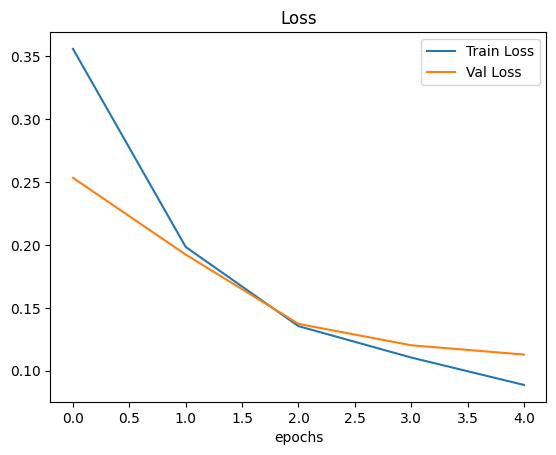

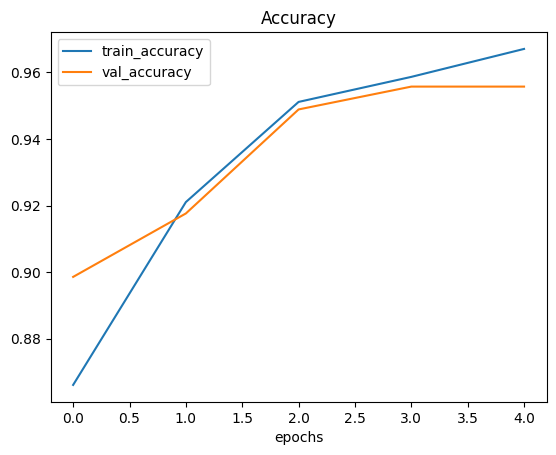

In [12]:
#Use out function
plot_loss_curves(Model_1_History)

## Second Stage Training
* unfreaze Last 10 Layers of the Base model
* Lower the learning rate of Adam optimizer

In [13]:
# Un freaze all the Base_model
base_model.trainable = True

#Freezing all the layers except last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False


#ReCompile the model
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), #--< When FineTuning u want to lower the LR by 10x
                metrics = ["accuracy"]
               )


#FineTune for 10 epochs
initial_epoch = 5

Fine_Tune_epoch = initial_epoch + 5

#Refit the model
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch ,
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 56s 189ms/step - accuracy: 0.9589 - loss: 0.1146 - val_accuracy: 0.9641 - val_loss: 0.0927
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9828 - loss: 0.0583 - val_accuracy: 0.9748 - val_loss: 0.0755
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9862 - loss: 0.0459 - val_accuracy: 0.9741 - val_loss: 0.0662
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9887 - loss: 0.0359 - val_accuracy: 0.9756 - val_loss: 0.0763
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9920 - loss: 0.0308 - val_accuracy: 0.9786 - val_loss: 0.0623
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9928 - loss: 0.0260 - val_accuracy: 0.9786 - val_loss: 0.0617


In [14]:
#ReCompile the model and reduce Learning rate by 10x
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001), #--< lower the LR by 10x
                metrics = ["accuracy"]
               )
initial_epoch = 10
Fine_Tune_epoch = initial_epoch + 1
#Refit the model for 2 more epochs
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch ,
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

Epoch 10/11
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 186ms/step - accuracy: 0.9939 - loss: 0.0232 - val_accuracy: 0.9786 - val_loss: 0.0552
Epoch 11/11
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9976 - loss: 0.0155 - val_accuracy: 0.9809 - val_loss: 0.0528


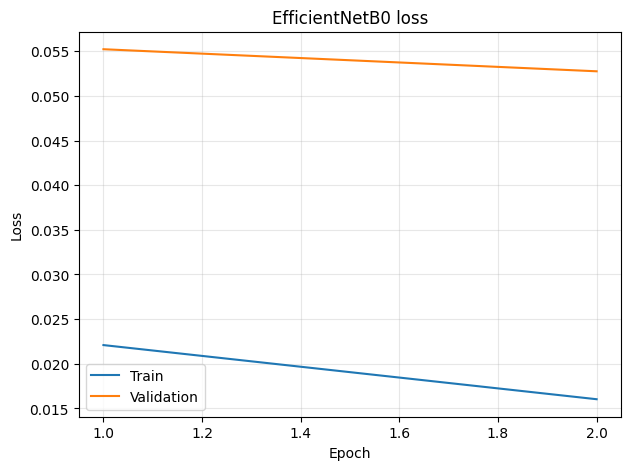

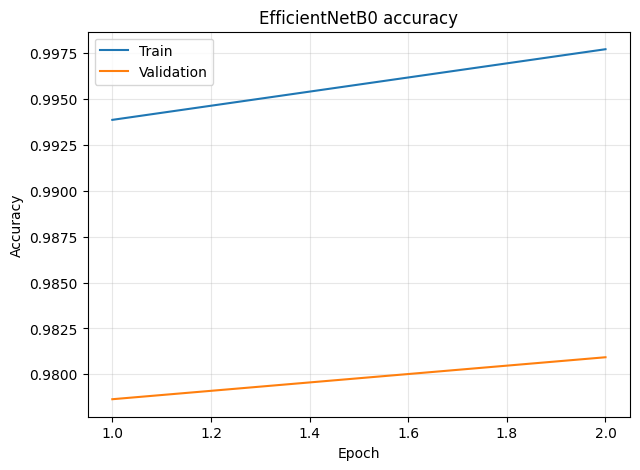

In [19]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title_prefix="Model"):
    # Get curves
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])

    epochs = range(1, len(loss) + 1)

    # ---- Plot Loss ----
    plt.figure(figsize=(7,5))
    plt.plot(epochs, loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.title(f"{title_prefix} loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # ---- Plot Accuracy ----
    plt.figure(figsize=(7,5))
    plt.plot(epochs, acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.title(f"{title_prefix} accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
plot_training_curves(Stage_2_history, title_prefix="EfficientNetB0")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test samples: 1311

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9760    0.9500    0.9628       300
  meningioma     0.9519    0.9706    0.9612       306
     notumor     1.0000    1.0000    1.0000       405
   pituitary     0.9901    0.9967    0.9934       300

    accuracy                         0.9809      1311
   macro avg     0.9795    0.9793    0.9793      1311
weighted avg     0.9810    0.9809    0.9809      1311


Métriques agrégées :
Accuracy: 0.9809
PU (precision) macro: 0.9795
PA (recall)    macro: 0.9793
F1-score       macro: 0.9793
PU (precision) weighted: 0.9810
PA (recall)    weighted: 0.9809
F1-score       weighted: 0.9809
PU (precision) micro: 0.9809
PA (recall)    micro: 0.9809
F1-score       micro: 0.9809

---- PA / PU par classe ----
glioma: PA=0.9500, PU=0.9760
meningioma: PA=0.9706, PU=0.9519
notumor: PA=1.0000, PU=1.0000
pituitary: PA=0.9967, PU=0.9901



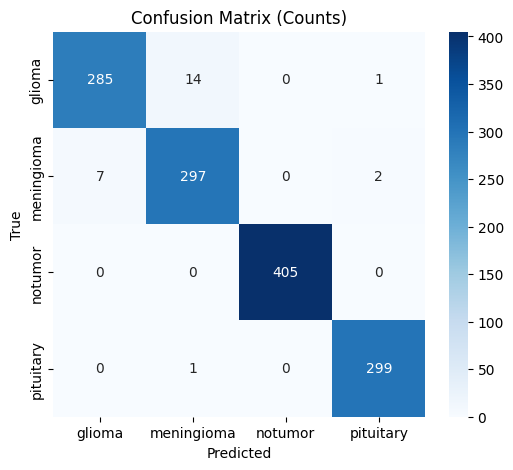

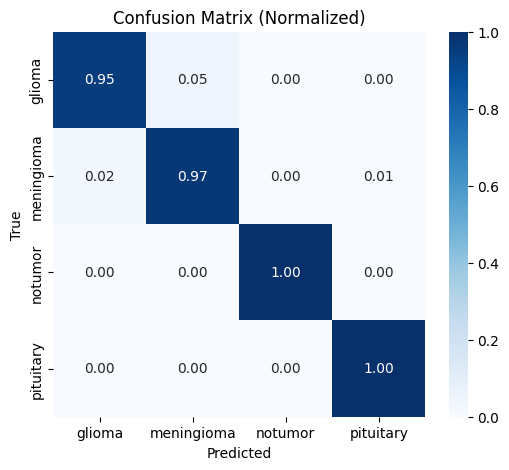

<Figure size 1000x400 with 0 Axes>

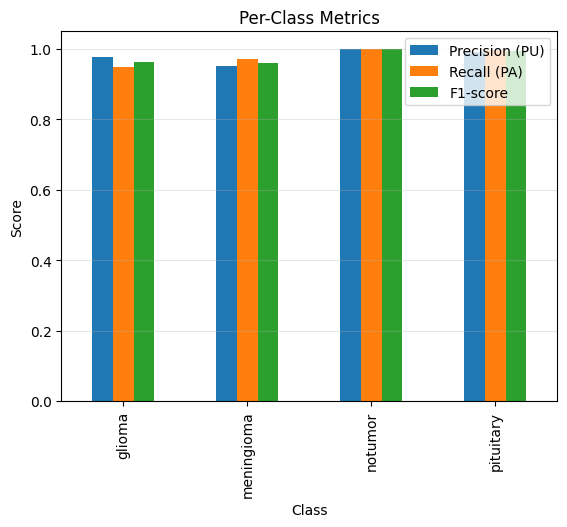

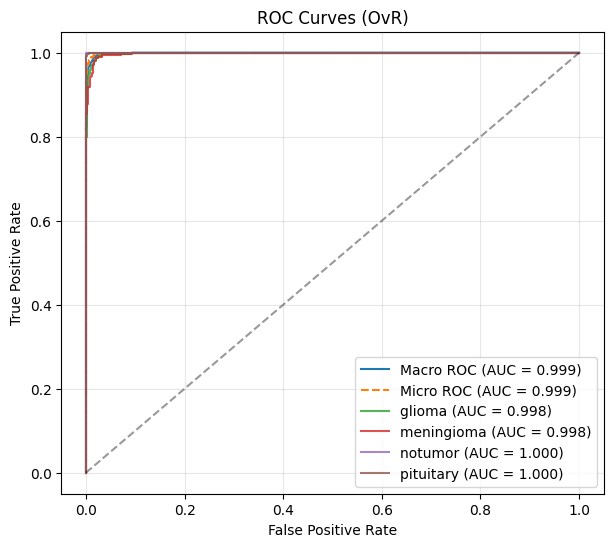


AUC Summary:
AUC macro : 0.9991
AUC micro : 0.9994
AUC glioma: 0.9985
AUC meningioma: 0.9978
AUC notumor: 1.0000
AUC pituitary: 1.0000


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# ============ 1) Get y_true and y_pred from tf.data ============
def get_true_and_pred(model, dataset):
    y_true = []
    y_prob = []

    for x_batch, y_batch in dataset:
        probs = model.predict(x_batch, verbose=0)
        y_prob.append(probs)
        y_true.append(np.argmax(y_batch.numpy(), axis=1))

    y_true = np.concatenate(y_true)
    y_prob = np.concatenate(y_prob)
    y_pred = np.argmax(y_prob, axis=1)
    return y_true, y_pred, y_prob

y_true, y_pred, y_prob = get_true_and_pred(Model_1, test_data)

# Class names (from your train_data)
class_names = train_data.class_names
n_classes = len(class_names)

print("Classes:", class_names)
print("Test samples:", len(y_true))

# ============ 2) Classification report ============
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ============ 3) Aggregated metrics: macro / weighted / micro ============
# PU = Precision, PA = Recall
PU_macro = precision_score(y_true, y_pred, average='macro')
PA_macro = recall_score(y_true, y_pred, average='macro')
F1_macro = f1_score(y_true, y_pred, average='macro')

PU_weighted = precision_score(y_true, y_pred, average='weighted')
PA_weighted = recall_score(y_true, y_pred, average='weighted')
F1_weighted = f1_score(y_true, y_pred, average='weighted')

PU_micro = precision_score(y_true, y_pred, average='micro')
PA_micro = recall_score(y_true, y_pred, average='micro')
F1_micro = f1_score(y_true, y_pred, average='micro')

acc = (y_true == y_pred).mean()

print("\nMétriques agrégées :")
print(f"Accuracy: {acc:.4f}")
print(f"PU (precision) macro: {PU_macro:.4f}")
print(f"PA (recall)    macro: {PA_macro:.4f}")
print(f"F1-score       macro: {F1_macro:.4f}")
print(f"PU (precision) weighted: {PU_weighted:.4f}")
print(f"PA (recall)    weighted: {PA_weighted:.4f}")
print(f"F1-score       weighted: {F1_weighted:.4f}")
print(f"PU (precision) micro: {PU_micro:.4f}")
print(f"PA (recall)    micro: {PA_micro:.4f}")
print(f"F1-score       micro: {F1_micro:.4f}")

# ============ 4) PA / PU per class (like your screenshot) ============
prec_per_class = precision_score(y_true, y_pred, average=None)
rec_per_class  = recall_score(y_true, y_pred, average=None)

print("\n---- PA / PU par classe ----")
for i, name in enumerate(class_names):
    PA = rec_per_class[i]   # recall
    PU = prec_per_class[i]  # precision
    print(f"{name}: PA={PA:.4f}, PU={PU:.4f}")

print(f"\nPA moyenne (macro): {PA_macro:.4f}")
print(f"PU moyenne (macro): {PU_macro:.4f}")

# ============ 5) Confusion matrix (raw + normalized) ============
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============ 6) Bar plots for per-class precision/recall/f1 ============
report_dict = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True
)

per_class_df = pd.DataFrame({
    "Class": class_names,
    "Precision (PU)": [report_dict[c]["precision"] for c in class_names],
    "Recall (PA)":    [report_dict[c]["recall"] for c in class_names],
    "F1-score":       [report_dict[c]["f1-score"] for c in class_names],
    "Support":        [report_dict[c]["support"] for c in class_names],
})

plt.figure(figsize=(10,4))
per_class_df.set_index("Class")[["Precision (PU)", "Recall (PA)", "F1-score"]].plot(kind="bar")
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)
plt.show()

# ============ 7) ROC + AUC (One-vs-Rest multi-class) ============
# binarize true labels
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC
plt.figure(figsize=(7,6))
plt.plot(fpr["macro"], tpr["macro"], label=f"Macro ROC (AUC = {roc_auc['macro']:.3f})")
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro ROC (AUC = {roc_auc['micro']:.3f})", linestyle="--")

for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC = {roc_auc[i]:.3f})", alpha=0.8)

plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.title("ROC Curves (OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print("\nAUC Summary:")
print(f"AUC macro : {roc_auc['macro']:.4f}")
print(f"AUC micro : {roc_auc['micro']:.4f}")
for i, name in enumerate(class_names):
    print(f"AUC {name}: {roc_auc[i]:.4f}")


# Segmentation part Using Grad-cam 🟥


### Define some Functions

In [ ]:
#Define Some Functions :

last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (224 , 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model = Model_1 , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))



def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction



def make_prediction (img_path , model = Model_1 , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = Model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]

# Trying the segmentation on 1 MRI image


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))



meningioma


(np.float64(-0.5), np.float64(317.5), np.float64(353.5), np.float64(-0.5))

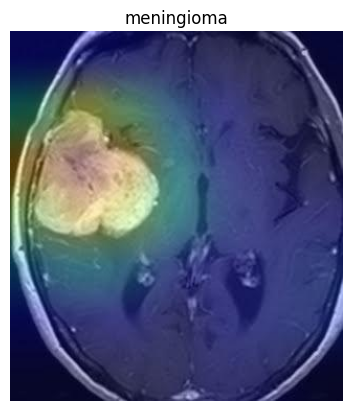

In [ ]:
campath , prediction = make_prediction("/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0025.jpg" , campath="123.jpeg" , view = False)
print(prediction)
test_img = img.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")

# Trying the segmentation on 9 MRI images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


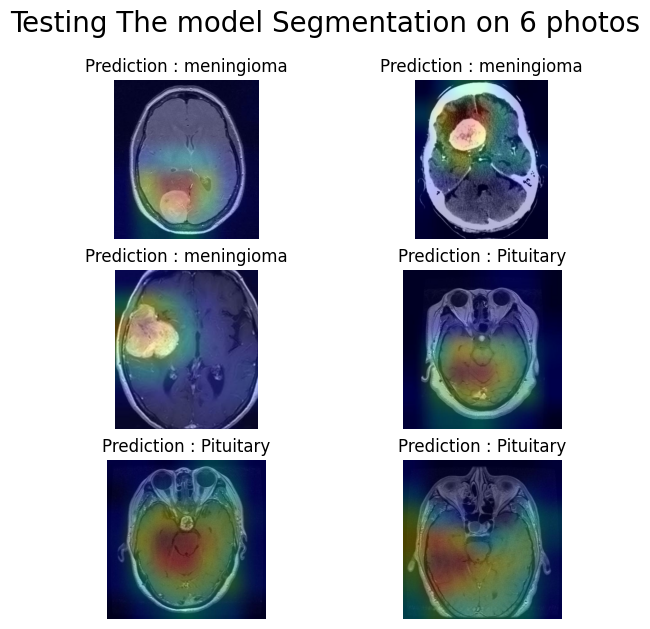

In [ ]:
#Define photos paths :
path_array = [
  '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0010.jpg',
  '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0015.jpg' ,
  '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0025.jpg' ,
  '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0010.jpg' ,
  '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0021.jpg' ,
  '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0030.jpg' ,

]


fig = plt.figure(figsize=(7, 7))
fig.suptitle("Testing The model Segmentation on 6 photos" , fontsize = 20)
for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        campath , prediction = make_prediction(path_array[i] , campath=f"{i}.jpeg")
        test_img = img.imread(campath)
        plt.imshow(test_img)
        plt.title("Prediction : " + prediction)
        plt.axis("off")